In [1]:
import keras
import numpy as np
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, AveragePooling2D
from keras.initializers import RandomNormal  
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras.callbacks import LearningRateScheduler, TensorBoard
from keras import backend as K
if('tensorflow' == K.backend()):
    import tensorflow as tf
    from keras.backend.tensorflow_backend import set_session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)

Using TensorFlow backend.


In [0]:
# standardize input
def color(x_train,x_test):
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    mean = [125.307, 122.95, 113.865]
    std  = [62.9932, 62.0887, 66.7048]
    for i in range(3):
        x_train[:,:,:,i] = (x_train[:,:,:,i] - mean[i]) / std[i]
        x_test[:,:,:,i] = (x_test[:,:,:,i] - mean[i]) / std[i]
    return x_train, x_test

# set learning rate
def learningrate(epoch):
    if epoch <= 60:
        return 0.05
    if epoch <= 120:
        return 0.01
    if epoch <= 160:    
        return 0.002
    return 0.001


In [0]:
# set hyperparameters
batch_size    = 256
epochs        = 100
iterations    = 400
classes       = 10
dropout       = 0.5
weight_decay  = 0.0002
log_filepath  = './log'
#!tensorboard --logdir=/nin_bn

In [0]:
# build NIN model
def NIN():
  model = Sequential()

  model.add(Conv2D(192, (5, 5), padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv2D(160, (1, 1), padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv2D(96, (1, 1), padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(3, 3),strides=(2,2),padding = 'same'))
  
  model.add(Dropout(dropout))
  
  model.add(Conv2D(192, (5, 5), padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv2D(192, (1, 1),padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv2D(192, (1, 1),padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(3, 3),strides=(2,2),padding = 'same'))
  
  model.add(Dropout(dropout))
  
  model.add(Conv2D(192, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv2D(192, (1, 1), padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv2D(10, (1, 1), padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  
  model.add(GlobalAveragePooling2D())
  model.add(Activation('softmax'))
  
  sgd = optimizers.SGD(lr=.1, momentum=0.9, nesterov=True)
  model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
  return model

In [5]:
if __name__ == '__main__':

    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    y_train = keras.utils.to_categorical(y_train, classes)
    y_test = keras.utils.to_categorical(y_test, classes)
    x_train, x_test = color(x_train, x_test)
    
    model = NIN()
    print(model.summary())
    
    tb_cb = TensorBoard(log_dir=log_filepath, histogram_freq=0,  write_graph = True, write_images = False)
    change_lr = LearningRateScheduler(learningrate)
    cbks = [change_lr,tb_cb]

    print('Data Augmentation.')
    datagen = ImageDataGenerator(horizontal_flip=True,width_shift_range=0.125,height_shift_range=0.125,fill_mode='constant',cval=0.)
    datagen.fit(x_train)
    
    history = model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),steps_per_epoch=iterations,epochs=epochs,callbacks=cbks,validation_data=(x_test, y_test))
    #model.save('nin_bn.h5')

170500096/170498071 [==============================] - 36s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 192)       14592     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 192)       768       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 192)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 160)       30880     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 160)       640       
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 160)       0         
_________________________________________________________________
conv2d_3

In [6]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2018-12-17 00:48:33--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.231.75.48, 34.204.22.7, 34.199.255.1, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.231.75.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5363700 (5.1M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]   5.11M  7.85MB/s    in 0.7s    

2018-12-17 00:48:34 (7.85 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [5363700/5363700]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
Traceback (most recent call last):
  File "<string>", line 1, in <module>
IndexError: list index out of range


dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


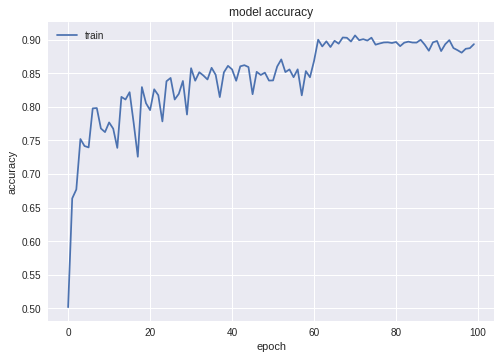

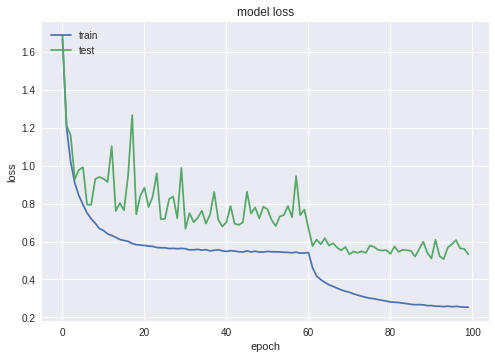

In [7]:
import matplotlib.pyplot as plt
print(history.history.keys())

plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()